<img src=../figures/Brown_logo.svg width=50%>

# Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture 25

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

### Suryanarayanan M. S. | <a href = "mailto: s.manojsanu@tudelft.nl">s.manojsanu@tudelft.nl</a>  | PhD Candidate

# Outline for today's lecture
* Recap of previous lecture
* Zeroth-order optimizers
* Optimality criteria
* Gradient-based optimizers
    
**References:**
* J. R. R. Martins & Andrew Ning, Engineering Design Optimization, 2021 - Chapters 1 & 4
* For practical details of algorithms (Extra):
    * Nocedal, Jorge, and Stephen J. Wright. Numerical optimization. Springer Science & Business Media, 2006.
* For Adam, momemtum & Adagrad
    * Ian Goodfellow and Yoshua Bengio and Aaron Courville. Deep Learning. MIT Press, 2016 - Chapter 8

## Recap & contextualization
<img align=right src="./figures/recap.png" width=40%>

**1. Unconstrained minimization**

**2. Convex functions look like bowls**
* Well behaved     
* Every function has convex local approximations!  

**3. Optimizer tradeoff**
* Exploration vs exploitation  
* Order of information (Taylor series expansion)

In [1]:
# Basic plotting tools needed in Python.
import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

In [2]:
class FunctionPlot():
    """Simple class to manage plotting of a function.

    Plot the function, its first order model and its second order model.
    All of these can be plotted one by one interactively.
    """
    def __init__(self, bounds=50, convex=True):
        self.count = 0
        self.saved_x = []  # Saved every input received
        self.line = None
        self.bounds = bounds  # Bounds on the decision variable
        self.convex = convex

        self.random_coeff = np.random.choice([-25, -15, 10, 20])  # For the underlying function
        self.sine_coeff = 100
        self.sine_freq = 0.2
        self.show_canvas()

    def underlying_func(self, x):
        """True function.
        Sum of two functions:
        1. A quadratic function with a random coefficient
        The form is ax**2 - bx + c, where a is 1, b is random_coeff and c is 1.
        2. a*sine(b*x) 
        """
        if self.convex:
            return x**2 - self.random_coeff*x + 1
        else:
            return x**2 - self.random_coeff*x + 1 + self.sine_coeff*np.sin(self.sine_freq*x)

    def gradient(self, x):
        """The gradient of the underlying function."""
        if self.convex:
            return 2*x - self.random_coeff
        else:
            return 2*x - self.random_coeff + self.sine_coeff*self.sine_freq*np.cos(self.sine_freq*x)

    def hessian(self, x):
        if self.convex:
            return 2
        else:
            return 2 - self.sine_coeff*self.sine_freq**2*np.sin(self.sine_freq*x)

    def first_order_model(self, x, x0):
        """The first order model of the underlying function."""
        return self.underlying_func(x0) + self.gradient(x0)*(x - x0)

    def second_order_model(self, x, x0):
        """The second order model of the underlying function."""
        return self.underlying_func(x0) + self.gradient(x0)*(x - x0) + 0.5*self.hessian(x0)*(x - x0)**2

    def show_canvas(self):
        """Shows the figure on which to plot along with the bounds."""
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.set_xlabel('x')
        ax.set_ylabel('y = f(x)')
        ax.set_xlim(-self.bounds, self.bounds)
        ax.axvline(x=-self.bounds+3, color='r')  # To show the limit
        ax.axvline(x=self.bounds-3, color='r')
        self.fig = fig
        self.ax = ax

    def plot(self, x_value, with_first_order=False, with_second_order=False):
        """Plots the function, its first order model or its second order model."""
        self.count += 1
        self.saved_x.append(x_value)

        self.ax.plot(self.saved_x,
                         [self.underlying_func(x) for x in self.saved_x], 'bo')

        if with_first_order:
            self._plot_first_order_model()
        elif with_second_order:
            self._plot_second_order_model()
        else:
            pass

#         self.ax.legend()
        plt.show()

    def _plot_first_order_model(self):
        if self.line is not None:
            self.line.pop(0).remove()
        x = np.linspace(-self.bounds, self.bounds, 100)
        y = self.first_order_model(x, self.saved_x[-1])
        self.line = self.ax.plot(x, y, 'r--', label='First-order model')

    def _plot_second_order_model(self):
        if self.line is not None:
            self.line.pop(0).remove()
        x = np.linspace(-self.bounds, self.bounds, 100)
        y = self.second_order_model(x, self.saved_x[-1])
        self.line = self.ax.plot(x, y, 'r--', label='Second-order model')

    def plot_minimum(self):
        """Shows the minimum of the function."""
        if self.convex:
            min_x = self.random_coeff / 2
            min_y = self.underlying_func(min_x)
        else:
            x = np.linspace(-self.bounds, self.bounds, 200)
            yvals = self.underlying_func(x)
            min_x = x[np.argmin(yvals)]
            min_y = np.min(yvals)            
        
        self.ax.plot(min_x, min_y, 'x', markersize=20, color='b', label='Minimum')

    def plot_func(self):
        x = np.linspace(-self.bounds, self.bounds, 100)
        y = self.underlying_func(x)
        self.ax.plot(x, y, "b:",label='True function')


# Exercise: walking as an optimizer

* Understand different optimizers
    * How they perceive the objective function landscape
* Blue dots - Underlying function
* Red lines - bounds
* Red cross - Minima

#### We will see how important information is!


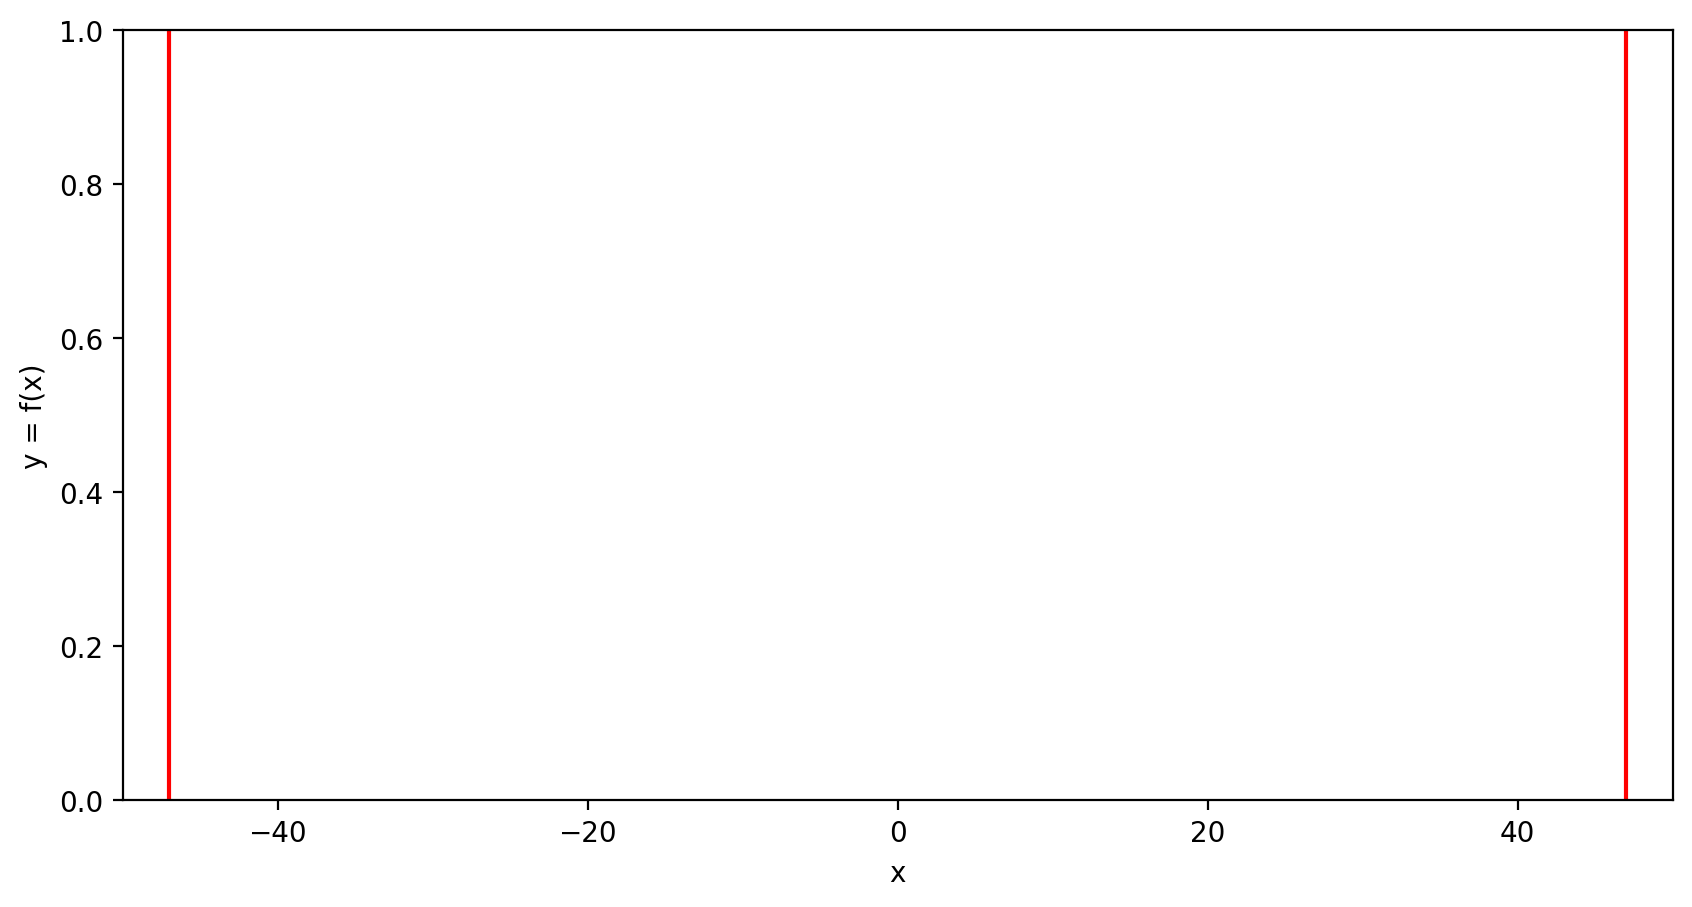

In [3]:
# Create the object separately in a cell
plotter = FunctionPlot(convex=False, bounds=50)

# Zeroth-order optimizers
* Black-box / derivative-free optimizers
    * Only access function's outputs
* Used extensively for hyper-parameter optimization
    * Decision variables are discrete (or mixed)
    * Discontinuous functions
        * Gradient and Hessian are not defined (or not used or not accessible)

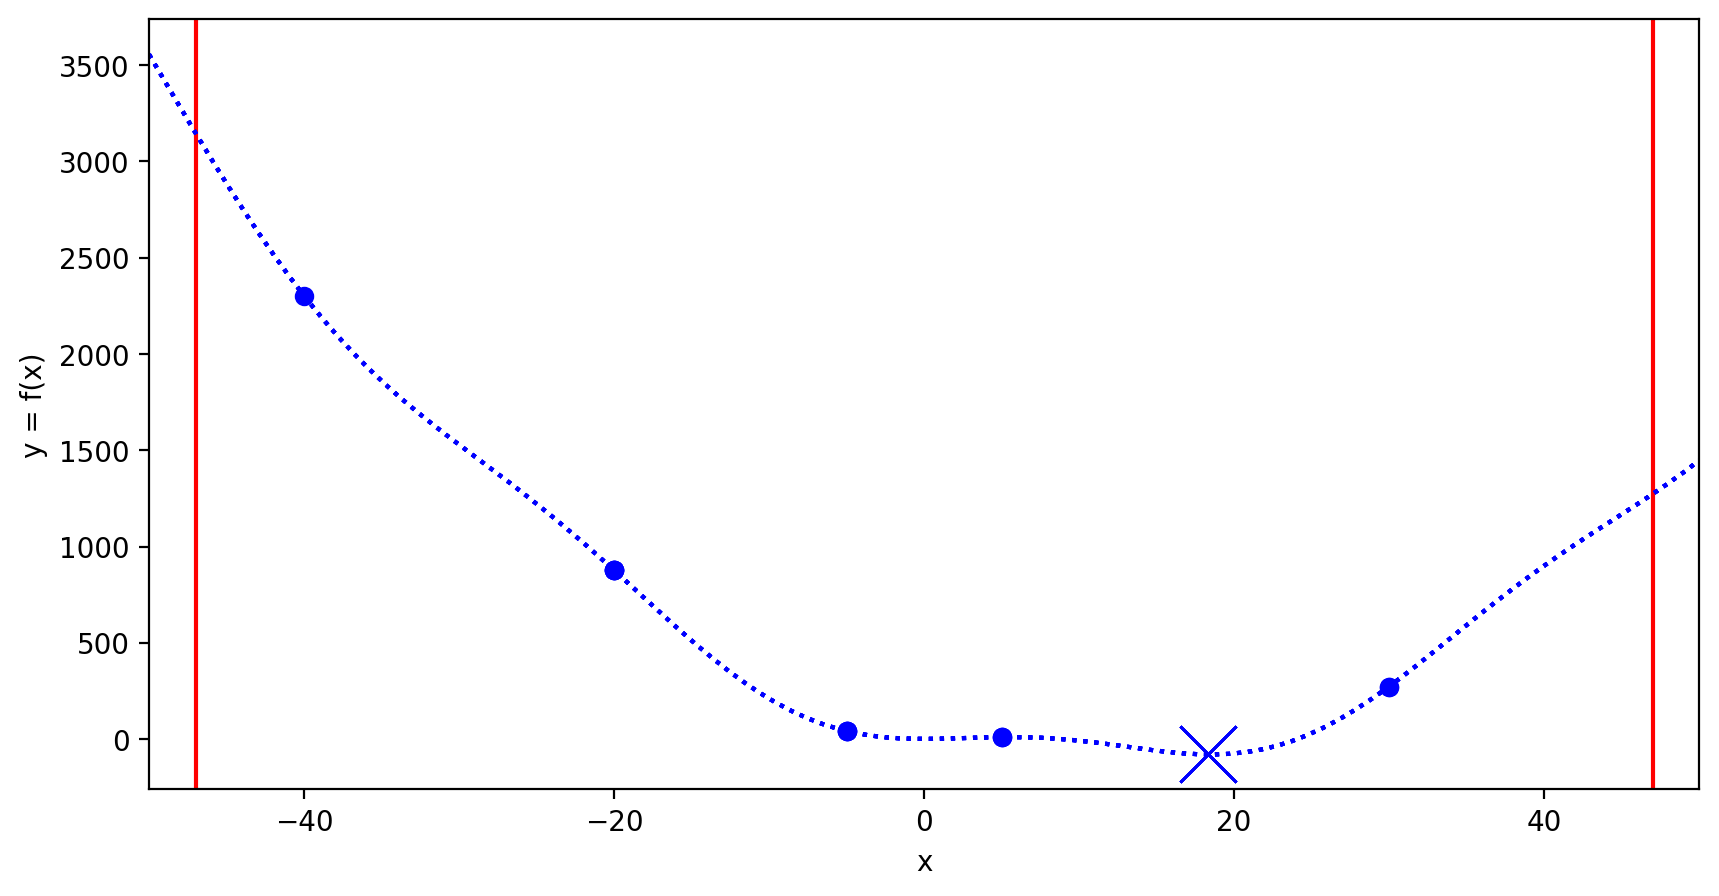

In [8]:
x = -40  # Make guesses!
plotter.plot(x)
plotter.plot_minimum()
plotter.plot_func()
plotter.fig

### Issues with Zeroth-order methods
* Not very efficient.
    * The number of function evaluations increases exponentially with dimensionality.
        * `Curse of dimensionality`.

* Usually do not know when to stop!
    * **Cannot identify minima**

# How to know a minima if we see one

* Minima are defined as points better than their neighbourhood
* To identify minima
    * "Look" around a point
* We need a local model of the objective function

**Local model using Taylor series**


$$ f(\mathbf{x} + \alpha \mathbf{p})|_{\mathbf{x}=\mathbf{x}_0} \approx f(\mathbf{x}_0) + \alpha \nabla f(\mathbf{x}_0)^T \mathbf{p} + \frac{1} {2}\alpha^2 \mathbf{p}^T   \mathbf{H}(\mathbf{x}_0)   \mathbf{p}$$

$$ \text{Gradient: } \nabla f(\mathbf{x}) = \Big[\frac{\partial f}{ \partial x_1}, \frac{\partial f}{ \partial x_2} ..., \frac{\partial f}{ \partial x_{D_x}} \Big]^T$$


$$ \text{Hessian: } H(\mathbf{x}) = \begin{bmatrix} \frac{\partial^2 f}{\partial x_1^2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_{D_x}} \\ \vdots &  \ddots & \vdots \\ \frac{\partial^2 f}{\partial x_{D_x} \partial x_1} & \cdots & \frac{\partial^2 f}{\partial x_{D_x}^2} \end{bmatrix} $$

**Need gradients and/or Hessian information**

## Optimality criteria

* Mathematical conditions to identify minima from other points!
* In practice,
    * Used internally by gradient-based optimizers
        * to find minima and to stop.
    * In constrained optimization
        * Optimality is checked with KKT (Karush-Kuhn-Tucker) conditions.

### First-order condition
* **At a local minimum, gradient should vanish.**
    * $\nabla f(\mathbf{x}^*) = \mathbf{0}$
<img align=right src="./figures/1d_optimality.png" width=50%>
* In one-dimension:
    * Slope = 0 at every minimum (High school calculus!)
* In multi-dimensions:
    * Gradient = collection of slopes
    * **Gradient** = **0**: Slope in every direction is zero
* If the gradient is non-zero
    * We can travel **opposite** to the gradient to reduce the function further.
    * (Remember that the gradient points in the ascent direction!)


🚨 **Gradient is zero at other places too** 🚨
* Stationary points
    * Local maxima
    * Saddle points!
    

* So how do we check ?

We could look at the Hessian...

### Second-order condition

* Hessian is the **curvature matrix**
    * Eigenvalues are curvatures along different directions
* Local minima
    * If Hessian = positive definite (all eigenvalues are > 0)
    * In one-dimension: $H(x^*) > 0$
* Local maxima
    * If Hessian = negative definite (all eigenvalues < 0)
* Saddle point
    * If Hessian has positive and negative eigenvalues
* If semi-definite (eigenvalues are exactly zero), then we are not sure!

<img src="./figures/hessian_stationary_points.png" width=60%>

## Gradient-based optimizers

<img align=centre src="./figures/opt_spectrum.png" width=50%>

* Spectrum: from first order to second order
    * Based on Taylor series local model

**Common steps:**

**1. They need a guess to start - Initialization**

**2. Update rule to make better guesses**

$\mathbf{x}_{k+1} = \mathbf{x}_k + \alpha \mathbf{p}$

* $\mathbf{p}$ is a **search direction**
    * Which direction to move ?
    * $\mathbf{p}$ depends on $\nabla f$
* $\alpha$ is a **step size** (in ML, sometimes called learning rate)
    * How much to move along $\mathbf{p}$ 
    * Can be a vector or scalar!
    
**3. Stopping criteria**
* E.g. $||\nabla f(\mathbf{x})|| \leq \epsilon $, where $\epsilon$ is some tolerance

## Gradient descent (GD)

* Simplest gradient-based optimizer
    * Utilize only gradients
    * Pure first-order

* Search direction , $\mathbf{p} = - \nabla f$
    * Steepest descent!
    * We are decreasing the function's value most rapidly.

* Step size, $\alpha$ = scalar
    * Same for all directions

* **Stochastic gradient descent (SGD)**
    * Common ML optimizer for large datasets
    * Gradient is estimated using **minibatches** (subsets of the training data; more on this later)
    * Full batch, i.e. when using full training data, SGD = GD

### Choosing step size matters

<img align=right src="./figures/lr.png" width=40%>

* Most important hyper-parameter
    * For most gradient-based optimizers
    * = Learning rate
* Too small, slow convergence
    * Less exploration
    * "Bad" local minimum
* Too large, can diverge
    * Oscillations
    
Common strategy in ML:
* Use **learning rate schedule**, instead of a constant step size
    * E.g. decrease learning rate slowly at each increment $t$:
    
$$\mathbf{x}_{t+1} = \mathbf{x}_t + \alpha_t \mathbf{p}$$

**Question**: Can you try to anticipate when **Stochastic Gradient Descent** (SGD) is used instead of **Gradient Descent** (GD)?

1. For very large datasets and for models with many variables because GD would need a lot of memory to save all the gradients at each point

2. Also, because SGD does not use the complete gradient for the entire training dataset to update the model parameters, this causes "noise" and that can act as regularization!

We will discuss this in more detail when learning about artificial neural networks.

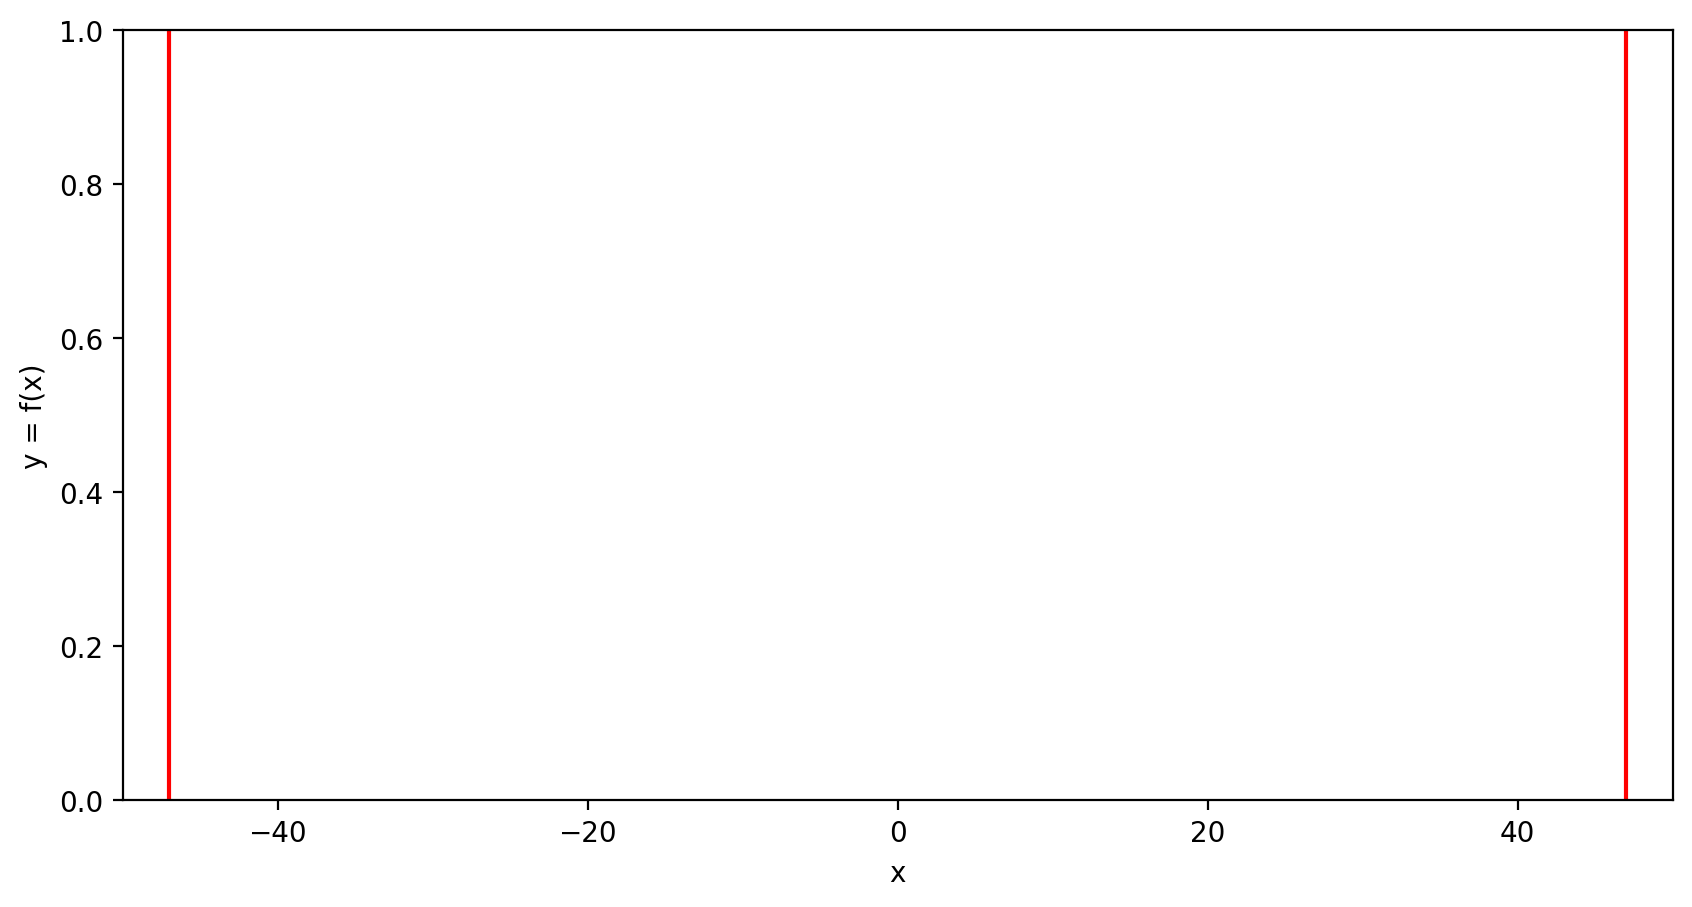

In [9]:
plotter = FunctionPlot(convex=True, bounds=50)

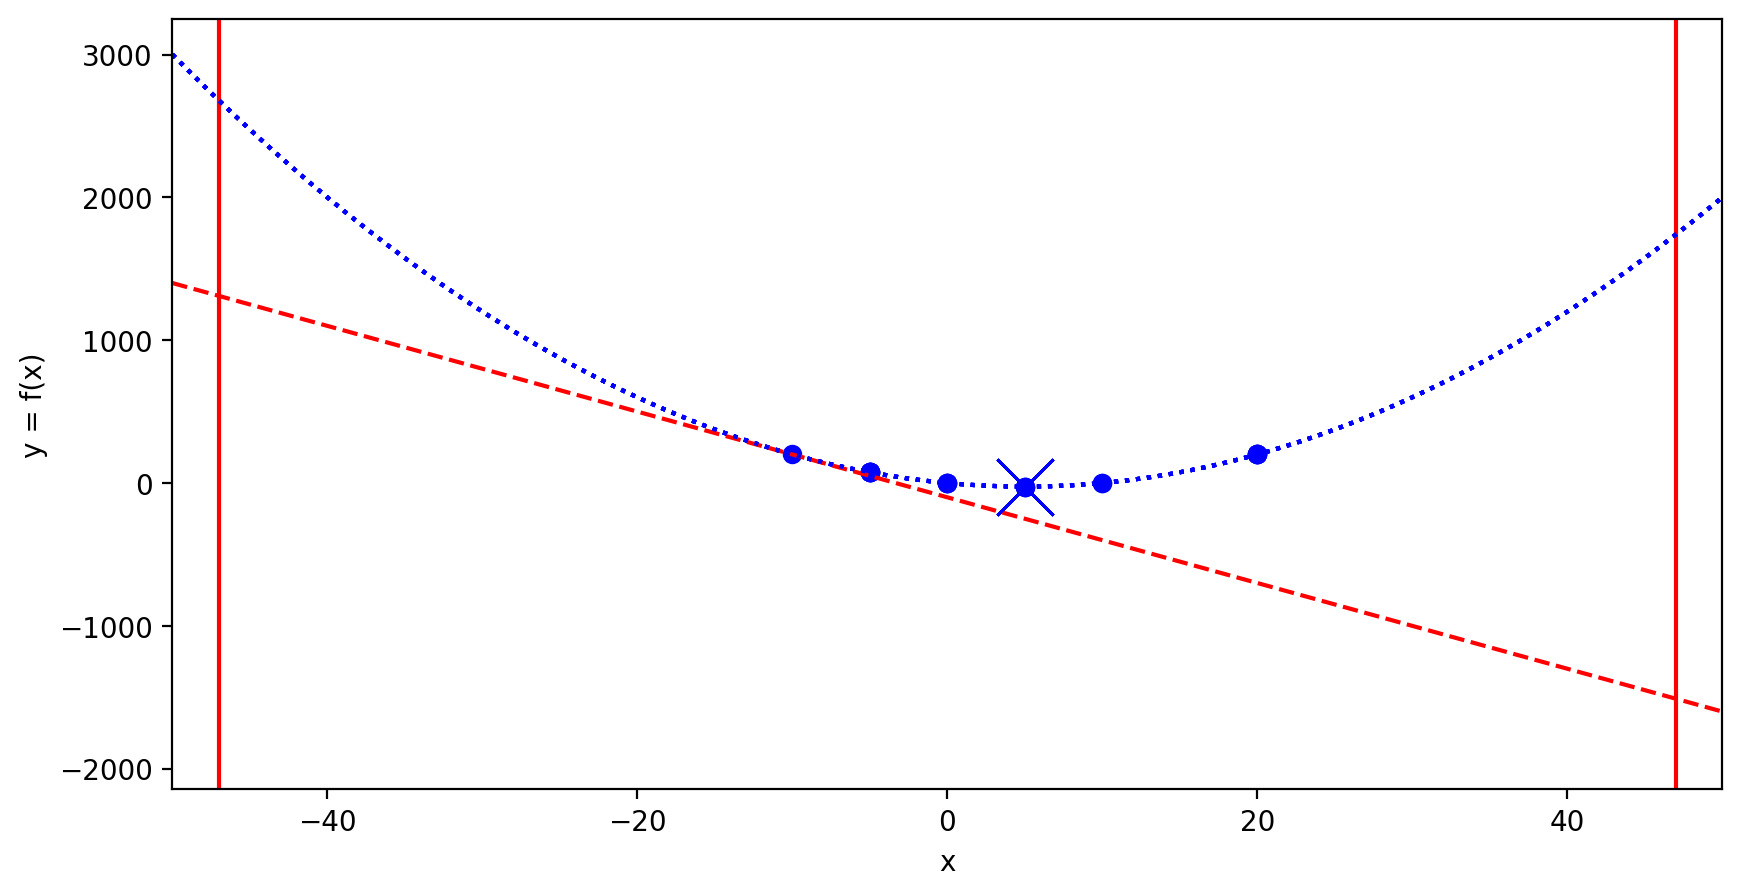

In [15]:
x = -10
plotter.plot(x, with_first_order=True)
plotter.plot_minimum()
plotter.plot_func()
plotter.fig

### Why should we not use GD always?

**Varying curvatures...**

Imagine the following 2D optimization problem:
* Change the length and thickness of a plate to improve its stiffness.
    * Decision (design or input) variables: (length, thickness)
    * length ~ 1m to 2m
    * thickness ~ 1mm to 2mm

**Question**: What do you think will happen to the gradients?

Recall that step size $\alpha$ is a **scalar**... And that in this case the gradient changes much faster in one direction than the other: **Scaling issues!**

<img src="./figures/gd_oscillation.png" width=40%>

* Curvature along "length" axis << curvature along "thickness" axis

* Hessian's eigenvalues would look something like this: $[1000, 1]$
    * **Slow progress along low curvature directions!** 

Besides adequately **scaling your dataset** (always scale your data!!), there are **two other approaches that we can use to move forward** 

1. Adjust the gradients, so that we get a better search direction

2. Adjust the step sizes individually

## Newton's method

Theoretically, a more powerful optimization method than first- and zero-order methods
* Uses both Gradient and Hessian
* Creates a quadratic assumption
* Goes to the quadratic bowl's minimum
    
Still follows the same update rule:

$$\mathbf{x}_{t+1} = \mathbf{x}_t + \alpha_t \mathbf{p}$$

But direction is dependent on the Hessian: $\mathbf{p} = - \mathbf{H}^{-1} \nabla f(\mathbf{x}_t)$

* This can be thought of as scaling the gradients according to the curvatures
    * It can be **independent of variable scaling**! (i.e. we could use $\alpha_t = 1$)
    * But in general, we can also associate a learning rate (or step size) $\alpha_t$ with a schedule.

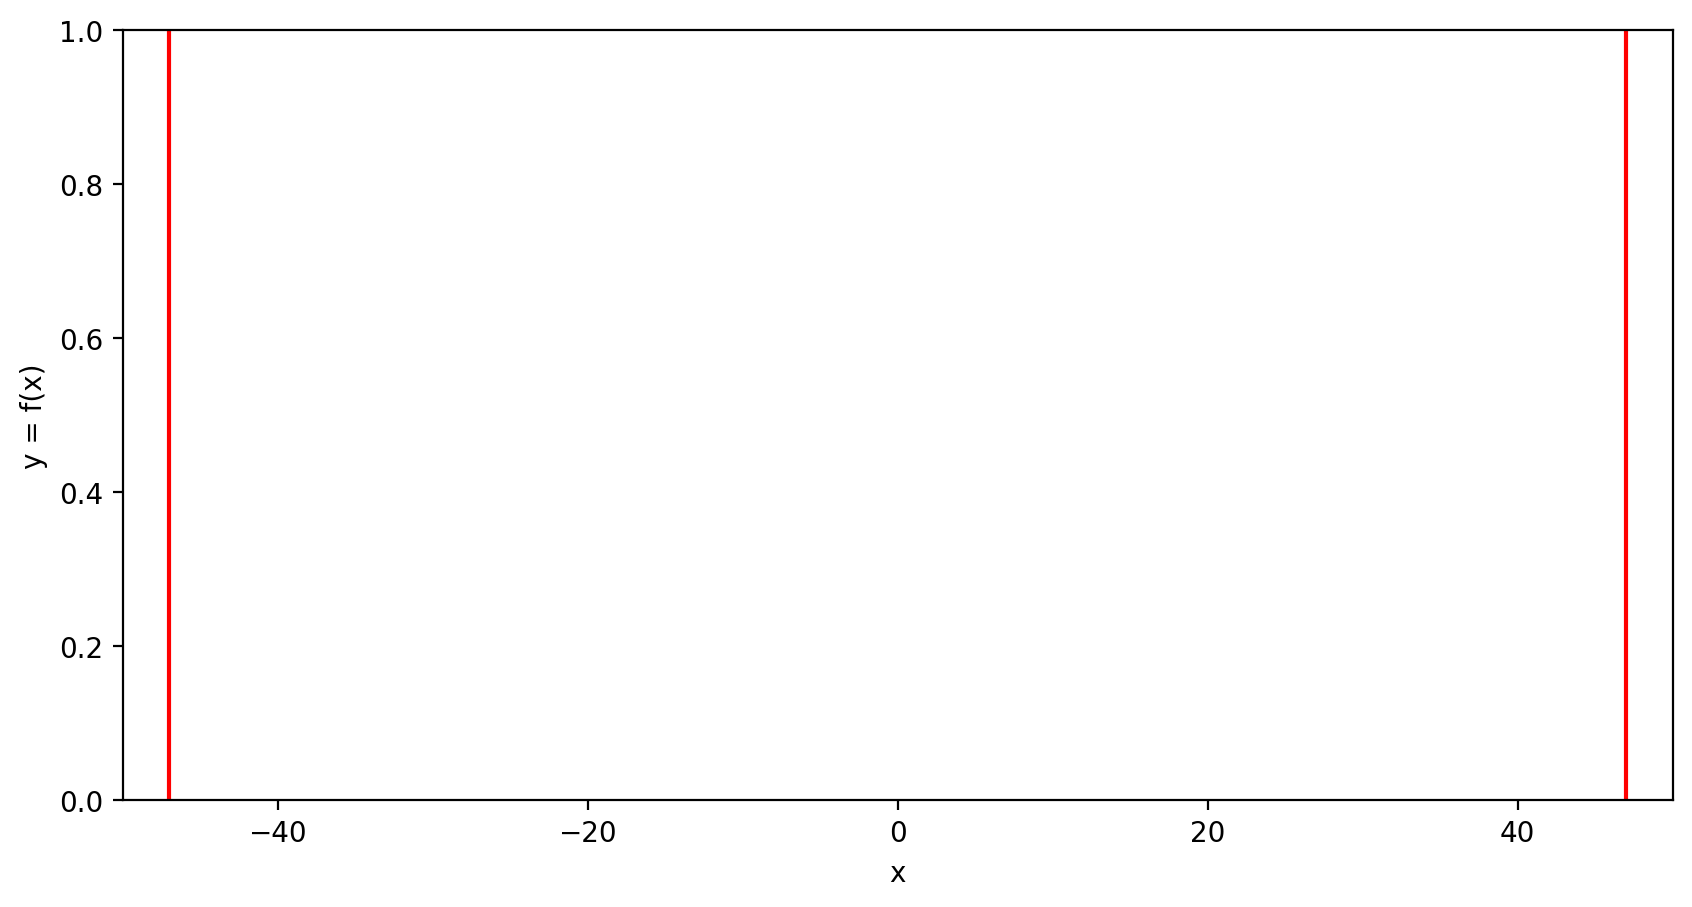

In [29]:
plotter = FunctionPlot(convex=True, bounds=50)

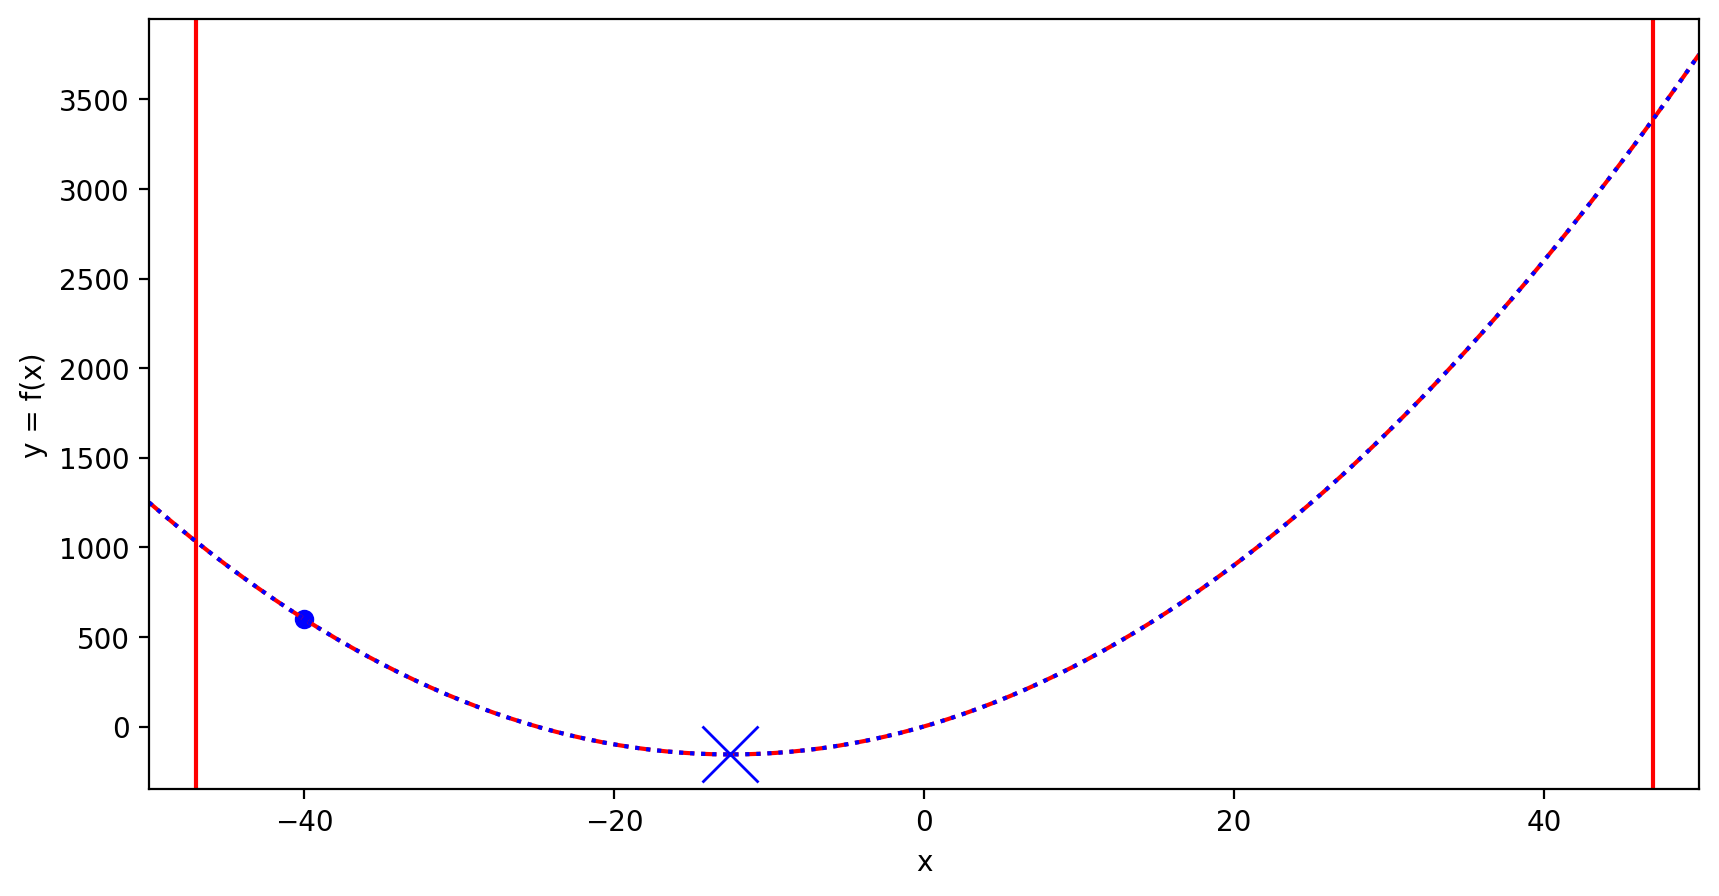

In [30]:
x = -40.0
plotter.plot(x, with_second_order=True)
plotter.plot_minimum()
plotter.plot_func()
plotter.fig

### Issues with Newton's method

* Calculating the Hessian
    * Storage
    * Expense
* Zero eigenvalues
    * Inversion does not exist
* Negative eigenvalues
    * Goes uphill 
        * They can cause the optimizer to increase the function value!

## Preconditioned strategies

**Preconditioned** strategies modify the original update rule:

$\mathbf{x}_{k+1} = \mathbf{x}_k + \alpha \mathbf{p}$

as follows:

$\mathbf{x}_{t+1} = \mathbf{x}_{t} -\alpha_t \mathbf{M}_t^{-1} \nabla f(\mathbf{x}_t)$

where $\mathbf{p} = -\mathbf{M}_t^{-1} \nabla f(\mathbf{x}_t)$

Matrix $\mathbf{M}_t$ is called the **preconditioning matrix** or **preconditioner**

### Quasi-Newton methods: L-BFGS example

Quasi-Newton methods try to approximate the Hessian (or its inverse):

$\mathbf{p} = - \mathbf{M}_t^{-1} \nabla f$

* $\mathbf{M}_t \approx \mathbf{H}(\mathbf{x}_t)$ 
    * $\mathbf{M}_t$ being positive definite

How to construct $\mathbf{M}_t$?

* Estimate curvature based on previous gradients!

A success case: **BFGS optimization algorithm**
* BFGS stands for the initials of its inventors: Broyden, Fletcher, Goldfarb, and Shanno
* It uses a clever update formula based on **storing all successive gradients** to approximate the Hessian
* Nice because we don't need to specify the learning rate (it's one!). This is a form of "Line Search".

However, it can be **expensive to store all successive gradients** to calculate $\mathbf{B}$

Instead, we can decide to store only the gradients of the last $m$ iterations!

* This is called the **L-BFGS** optimization algorithm
    * The "L-" stands for "limited" memory

### Other preconditioning examples: momentum strategies for Gradient Descent (GD)

* "Heavy ball" momentum
* **Idea: Assign more weight to gradient directions that are consistent**
    * If it oscillates in one direction, assign less weight

<img align=centre src="./figures/gd_momentum.png" width=50%>

#### General procedure:
* Analogy by thinking about a velocity vector (unit mass)
    * Exponentially weighted average of previous gradients
    * $\mathbf{v}_t = \beta \mathbf{v}_{t-1} - \alpha \nabla f$
        * $\beta$ is a scalar hyperparameter
        * Controls importance of previous gradients 
        
$\mathbf{x}_{t+1} = \mathbf{x}_{t} + \mathbf{v}_t$

where $\mathbf{v}_t = \alpha \left[\frac{\beta}{\alpha} (\mathbf{B} - \mathbf{I}) \nabla f\right]$
* Same step size for all directions, but using a particular type of preconditioner that depends on a matrix $\mathbf{B}$

## Adagrad optimizer

* **Idea : Different step sizes for each direction**
    * Using a history of squared gradients
    
It's easier to understand Adagrap in index notation:

$$\mathbf{x}_{t+1,d} = \mathbf{x}_{t,d} - \alpha_t \frac{1}{\sqrt{s_{t,d}+\epsilon}} \nabla f$$

where $d$ indicates the particular dimension of the input variable.

* $\epsilon$ = small number to prevent division by zero
* $\alpha_t$ = step size at increment $t$ (scalar hyperparameter)
* $s_{t,d}$ = sum of the squared gradients at past increments $i=1,...,t$:
    $$s_{t,d} = \sum_{i=1}^t \nabla f(x_{i,d})$$

### AdaGrad optimizer

* **Idea : Different step sizes for each direction**
    * Using a history of squared gradients
    
It's easier to understand Adagrap in index notation:

$$x_{t+1,d} = x_{t,d} - \alpha_t \frac{1}{\sqrt{s_{t,d}+\epsilon}} \frac{\partial f}{\partial x_{t,d}}$$

where $d$ indicates the particular dimension of the input variable.

* $\epsilon$ = small number to prevent division by zero
* $\alpha_t$ = step size at increment $t$ (scalar hyperparameter)
* $s_{t,d}$ = sum of the squared gradients at past increments $i=1,...,t$:
    $$s_{t,d} = \sum_{i=1}^t \left(\frac{\partial f}{\partial x_{i,d}}\right)^2$$

**AdaGrad** can also be written in matrix form:

$$\mathbf{x}_{t+1} = \mathbf{x}_{t} - \alpha_t\mathbf{M}_t^{-1} \nabla f(\mathbf{x}_t) $$

but be careful because each operation needs to be done **element-wise**, such that the preconditioner is:

$$\mathbf{M}_t^{-1} = \text{diag}(\mathbf{s}_t+\epsilon)^{1/2}$$

And the final expression in matrix form becomes:

$$\mathbf{x}_{t+1} = \mathbf{x}_{t} - \alpha_t\frac{1}{\sqrt{\mathbf{s}_{t}+\epsilon}} \odot \nabla f(\mathbf{x}_t) $$

* The symbol $\odot$ indicates that multiplication is element-wise.

## Adam: a widely used optimizer for neural networks

**Adam = Momentum + Adagrad**

* Uses momentum's velocity as aspect (for past gradients)
    * $\beta_1$ hyperparameter
* Modifies Adagrad with an exponential weighted average (for past squared gradients)
    * $\beta_2$ hyperparameter
* Performs some bias correction for the estimates
* $\alpha$ hyperparameter [learning-rate]

Read the original paper! [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)

# Summary

* Zeroth-order optimizers
    * Only choice for black-box functions
    * Curse of dimensionality
* Optimality criteria
    * Gradient and Hessian to identify minima
* Gradient-based optimizers
    * General format - search direction and step size
* GD (SGD)
    * Simple but oscillates
* Newton's method
    * Robust to scaling but costly
* Adam
    * adaptive step size +  modified search direction